# Inline holography with a simulated dataset
This notebook showcases the functionality of the inline_holo python module using a simulated focal series dataset. These functionalities are accessed using the scripts below, that can be taken as example code, modified and reused in different applications. The simulated dataset is generated from an input wave (Wave.hdf5) and parameters, also given below together in a separate cell. Multi-focus TIE and gaussian-process TIE algorithms are used to obtain the low-spatial frequency information from the focal series. The Gerchberg-Saxton algorithm is finally used to also include high-spatial frequencies in these solutions. Validation tests are produced to explore the quality of these solutions.

In [1]:
# some useful tools
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import hyperspy.api as hs

# inline_holo tools
from image_tools import *
from inline_holo import *
from inline_holo import ModifiedImage as ModI

from time import time as t

c:\users\johannes\anaconda3\lib\site-packages\skcuda\cublas.py:272: UserWarning: creating CUBLAS context to get version number
  warnings.warn('creating CUBLAS context to get version number')


The cell below defines some scripts used to run the calculations and to store the results in a consistent manner.

In [2]:
use_gpu = True

In [3]:
def noiser(fs, SNR, seed=None):
    # Remove padding and add some noise
    fsn = fs.unset_padding()
    fsn.data += add_noise_gauss(fsn.data, SNR,seed)

    # Re-do padding
    fsu = fsn.set_padding(((Nypad, Nypad), (Nxpad, Nxpad)), 'reflect')
    #fsu = fsn.set_padding(((200, 200), (200, 200)), 'constant', constant_values=fsn.data.mean())

    fsu.data = fsu.data.astype('float32')
    fsu.data = np.ascontiguousarray(fsu.data)
    fsu.data[fsu.data<0.] = 1e-4
    return fsu

def three_plane_slicer(fs, idz):
    # idz = 1, 2, 3...
    Ndz = np.int(np.floor(len(fs) / 2))
    n1 = Ndz-idz
    n2 = idz-Ndz if Ndz != idz else None
    fs_idz=fs.inav[n1:n2:idz]
    fs_idz.axes_manager[0].axis = zdef[n1:n2:idz]
    return fs_idz

def do_mftie(fsi, SNR, lothres, hithres, Nbutter=100):
    results = {'SNR': SNR, 
               'hithres': hithres, 
               'lothres': lothres,
               'defocus' : fsi.axes_manager[0].axis}

    # MFTIE
    mftie = MFTIE(fsi, use_gpu, lothres, hithres, alpha, SNR, Nbutter=Nbutter)
    phase = mftie(False)
    inv_lap = fsi.inav[len(fsi)//2+1:].deepcopy()
    inv_lap.data = mftie.inverse_laplacian.get()
    
    # MFTIE, validate
    PhV = phase.unset_padding().set_padding(((Nypad, Nypad), (Nxpad, Nxpad)), 'reflect')
    val = validation(PhV, phase_org, False)
    frc = val.run_fourier_ring_correlation(d2d=False)
    rmse_real, rmse_rcpr = val.run_rmse_check() 
    
    # save MFTIE results
    results.update({'Phi' : phase})
    results.update({'Nm2' : inv_lap})
    results.update({'k2H' : mftie.k2_hi_thres})
    results.update({'k2L' : mftie.k2_lo_thres})
    results.update({'frc' : frc})
    results.update({'RMSE2' : mftie.rmse2n})
    results.update({'Phi_dz': mftie.phdata.get()})
    
    rmse_rcpr.data = np.fft.fftshift(rmse_rcpr.data, (-2,-1))
    results.update({'rms' : rmse_rcpr.integrate_radial(False, 0)})
    
    return results

def do_gptie(fsi, Nsl):
    results = {'Nsl': Nsl, 
               'defocus' : fsi.axes_manager[0].axis[-1]}

    # GPTIE
    gptie = GPTIE(fsi, Nsl=Nsl)
    phase = gptie(False)
    
    # GPTIE, validate
    PhV = phase.unset_padding().set_padding(((Nypad, Nypad), (Nxpad, Nxpad)), 'reflect')
    val = validation(PhV, phase_org, False)
    frc = val.run_fourier_ring_correlation(d2d=False)
    rmse_real, rmse_rcpr = val.run_rmse_check() 
    
    
    # save GPTIE results
    results.update({'Phi' : phase})
    results.update({'frc' : frc})
    
    rmse_rcpr.data = np.fft.fftshift(rmse_rcpr.data, (-2,-1))
    results.update({'rms' : rmse_rcpr.integrate_radial(False, 0)})
    
    return results

def do_gsref(fsi, wave_init, ctf, Niters):
    results = {'Nsl': Niters, 
               'defocus' : fsi.axes_manager[0].axis[-1]}

    # GSref
    gsref = GS(fsi, wave_init, ctf, alpha, use_gpu)
    wave = gsref(Niters)
    
    # GSref, validate phase
    phase = wave.deepcopy()
    phase.data = np.angle(wave.data) 
    PhV = phase.unset_padding().set_padding(((Nypad, Nypad), (Nxpad, Nxpad)), 'reflect')
    val = validation(PhV, phase_org, False)
    frc_phi = val.run_fourier_ring_correlation(d2d=False)
    rmse_real, rmse_rcpr_phi = val.run_rmse_check() 
    
    # GSref, validate intensity
    amplitude = wave.deepcopy()
    amplitude.data = np.abs(wave.data) 
    AmV = phase.unset_padding().set_padding(((Nypad, Nypad), (Nxpad, Nxpad)), 'reflect')
    val = validation(AmV, ampli_org, False)
    frc_amp = val.run_fourier_ring_correlation(d2d=False)
    rmse_real, rmse_rcpr_amp = val.run_rmse_check() 
    
    # save GSref results
    results.update({'Phi' : phase})
    results.update({'frc_phi' : frc_phi})
    
    results.update({'Amp' : amplitude})
    results.update({'frc_amp' : frc_amp})
    
    rmse_rcpr_phi.data = np.fft.fftshift(rmse_rcpr_phi.data, (-2,-1))
    results.update({'rms_phi' : rmse_rcpr_phi.integrate_radial(False, 0)})
    
    rmse_rcpr_amp.data = np.fft.fftshift(rmse_rcpr_amp.data, (-2,-1))
    results.update({'rms_amp' : rmse_rcpr_amp.integrate_radial(False, 0)})
    
    return results

## 1. Define input parameters

In [45]:
# PARAMETERS
alpha       = 0.       # uScope: Convergergence (set to 0 for coherent illumiation)
NA          = 0.6      # uScope: Num Aperture 
wlen        = 0.5      # uScope: Wave-length
nref        = 1.       # uScope: Refractive index

defmin      = 1.0      # Experiment: Smallest defocus plane
defmax      = 150.     # Experiment: Largest defocus plane
Ndef        = 10       # Experiment: Number of defocus planes

fsmooth     = 2.       # FS-Simulation: Cosine-Bell smooth 

lothres     = 1.0      # MFTIE: low-freq threshold
hithres     = 0.25     # MFTIE: high-freq threshold
Nsl         = 50       # GPTIE: binning
Niters      = 25       # GSref: Iterations

In [46]:
# load original wave
wave = hs.load('Wave.hdf5')
wave.__class__ = ModI
Ny, Nx = wave.unset_padding().axes_manager.signal_shape
Nypad, Nxpad = (int(Ny/2), int(Nx/2))
wave = wave.unset_padding().set_padding(((Nypad, Nypad), (Nxpad, Nxpad)), 'reflect')

# calculate original phase
phase_org = wave.deepcopy()
phase_org.data = np.angle(wave.data)

# calculate original amplitude
ampli_org = wave.deepcopy()
ampli_org.data = np.abs(wave.data)

c:\users\johannes\anaconda3\lib\site-packages\hyperspy\io.py:341: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  if np.issubdtype(dtype, complex):
c:\users\johannes\anaconda3\lib\site-packages\hyperspy\_signals\complex_signal.py:97: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  if not np.issubdtype(self.data.dtype, complex):


In [47]:
# Useful to know
wnum = 2. * np.pi / wlen
q = np.linspace(0., wnum, 256)
q2= q**2.

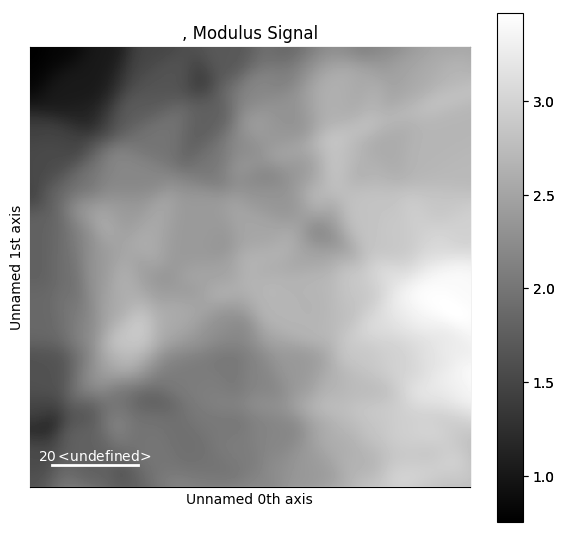

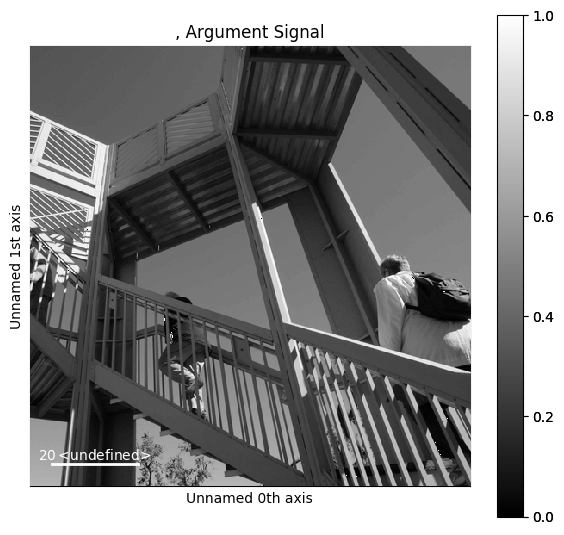

In [48]:
wave.unset_padding().plot(True)

## 2.A: 3 defoci experiment

Select the defocus planes for the simulation: 1, 5 and 10

In [10]:
SNR = 20

In [11]:
dz = np.array([1., 5., 10.])
zdef = np.concatenate( [-dz[::-1], np.array([0,]), dz])
print(np.round(zdef,1))

[-10.  -5.  -1.   0.   1.   5.  10.]


In [12]:
from CTFSim import CTFSim

# Project the wave to the selected planes
t0 = t()
ctsim = CTFSim(wave, zdef, alpha, use_gpu, None, wlen, nref, NA, 2.)
fs = ctsim(False)
Tsim = t()-t0
print('CTF-Sim time:', Tsim)

del CTFSim, ctsim 

E:\Documents\inline_holo\inline_holo.py:502: RuntimeWarning: invalid value encountered in sqrt
  Chi = np.sqrt(wnum**2-k2) - wnum


CTF-Sim time: 4.721403360366821


In [13]:
# Apply noise
fsn = noiser(fs, SNR, seed=12345)

# Do TIE !!!
sim_mfivx = do_mftie(fsn, SNR, lothres, hithres, Nbutter=1000)

# Get in-focus Amplitude
Nm  = get_middle(fsn)
amp = fsn.inav[Nm]

# Get init-waves
wave_ivx = sim_mfivx['Phi'].deepcopy()
wave_ivx.data = np.sqrt(amp.data) * np.exp(1j*sim_mfivx['Phi'].data)

# Get CTF
ctf = amp.get_contrast_transfer(zdef)

# Do GSref !!
sim_gsivx = do_gsref(fsn, wave_ivx, ctf, Niters)

E:\Documents\inline_holo\MFTIE.py:288: RuntimeWarning: divide by zero encountered in true_divide
  nabla_minus_2 = (1. / k2) * (1./(1.+(k2/k2Hi[:,None,None])**Nbutter)) * \
E:\Documents\inline_holo\MFTIE.py:288: RuntimeWarning: overflow encountered in power
  nabla_minus_2 = (1. / k2) * (1./(1.+(k2/k2Hi[:,None,None])**Nbutter)) * \
E:\Documents\inline_holo\MFTIE.py:289: RuntimeWarning: overflow encountered in power
  (1.-1./(1.+(k2/k2Lo[:,None,None])**Nbutter))
E:\Documents\inline_holo\MFTIE.py:289: RuntimeWarning: invalid value encountered in multiply
  (1.-1./(1.+(k2/k2Lo[:,None,None])**Nbutter))
E:\Documents\inline_holo\inline_holo.py:502: RuntimeWarning: invalid value encountered in sqrt
  Chi = np.sqrt(wnum**2-k2) - wnum
100%|██████████████████████████████████████████| 25/25 [00:03<00:00,  4.49it/s]


## 2.B: 21 defoci experiment

Select the defocus planes for the simulation: geometric progression. 

In [49]:
dz = np.logspace(np.log10(defmin), np.log10(defmax), 10)
zdef = np.concatenate( [-dz[::-1], np.array([0,]), dz])
print(np.round(zdef,1))

[-150.   -86.   -49.3  -28.2  -16.2   -9.3   -5.3   -3.    -1.7   -1.
    0.     1.     1.7    3.     5.3    9.3   16.2   28.2   49.3   86.
  150. ]


Additional noise level is higher.

In [50]:
SNR = 15

In [51]:
from CTFSim import CTFSim

# Project the wave to the selected planes
t0 = t()
ctsim = CTFSim(wave, zdef, alpha, use_gpu, None, wlen, nref, NA, 2.)
fs = ctsim(False)
Tsim = t()-t0
print('CTF-Sim time:', Tsim)

del CTFSim, ctsim 

E:\Documents\inline_holo\inline_holo.py:502: RuntimeWarning: invalid value encountered in sqrt
  Chi = np.sqrt(wnum**2-k2) - wnum


CTF-Sim time: 2.9375016689300537


In [52]:
# Apply noise
fsn = noiser(fs, SNR, seed=12345)

# Do TIE !!!
sim_mftie = do_mftie(fsn, SNR, lothres, hithres, Nbutter=10)
sim_gptie = do_gptie(fsn, Nsl)

# Get in-focus Amplitude
Nm  = get_middle(fsn)
amp = fsn.inav[Nm]

# Get init-waves
wave_mf = sim_mftie['Phi'].deepcopy()
wave_mf.data = np.sqrt(amp.data) * np.exp(1j*sim_mftie['Phi'].data)

wave_gp = sim_gptie['Phi'].deepcopy()
wave_gp.data = np.sqrt(amp.data) * np.exp(1j*sim_gptie['Phi'].data)

# Get CTF
ctf = amp.get_contrast_transfer(zdef)

# Do GSref !!
sim_mf_gs = do_gsref(fsn, wave_mf, ctf, Niters)
sim_gp_gs = do_gsref(fsn, wave_gp, ctf, Niters)

E:\Documents\inline_holo\MFTIE.py:288: RuntimeWarning: divide by zero encountered in true_divide
  nabla_minus_2 = (1. / k2) * (1./(1.+(k2/k2Hi[:,None,None])**Nbutter)) * \
E:\Documents\inline_holo\MFTIE.py:289: RuntimeWarning: invalid value encountered in multiply
  (1.-1./(1.+(k2/k2Lo[:,None,None])**Nbutter))
E:\Documents\inline_holo\GPTIE.py:149: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Coeff = np.linalg.lstsq(L, np.linalg.lstsq(L.T, D)[0])[0]
E:\Documents\inline_holo\inline_holo.py:502: RuntimeWarning: invalid value encountered in sqrt
  Chi = np.sqrt(wnum**2-k2) - wnum
100%|██████████████████████████████████████████| 25/25 [00:03<00:00, 11.18it/s]


## 3. plotting time

In [18]:
psi_list = [sim_gsivx['Phi'].unset_padding() + 0.3, sim_gsivx['Amp'].unset_padding(),  
            sim_mf_gs['Phi'].unset_padding() + 0.3, sim_mf_gs['Amp'].unset_padding(),   
            sim_gp_gs['Phi'].unset_padding() + 0.3, sim_gp_gs['Amp'].unset_padding()]

frc_list = [[sim_mfivx['frc'], sim_gsivx['frc_phi']],
            [sim_mftie['frc'], sim_mf_gs['frc_phi']],
            [sim_gptie['frc'], sim_gp_gs['frc_phi']]]

rms_list = [[sim_mfivx['rms'], sim_gsivx['rms_phi']],
            [sim_mftie['rms'], sim_mf_gs['rms_phi']],
            [sim_gptie['rms'], sim_gp_gs['rms_phi']]]

kax = sim_mftie['frc'].axes_manager[-1].axis

dz = sim_mfivx['defocus'].copy()
dz = dz[len(dz)//2+1:]
x_arrstr = np.char.mod('%i', dz)

dz = sim_mftie['defocus'].copy()
dzM = dz[len(dz)//2+1:].max()
dzm = dz[len(dz)//2+1:].min()
labels = [r'MFTIE, $\delta z='+",".join(x_arrstr)+'\mu m$',
          r'MFTIE, $\delta z='+np.str(dzm)+'-'+np.str(dzM)+'\mu m$',
          r'GPTIE, $\delta z='+np.str(dzm)+'-'+np.str(dzM)+'\mu m$',] 


### Waves

c:\users\johannes\anaconda3\lib\site-packages\matplotlib\figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


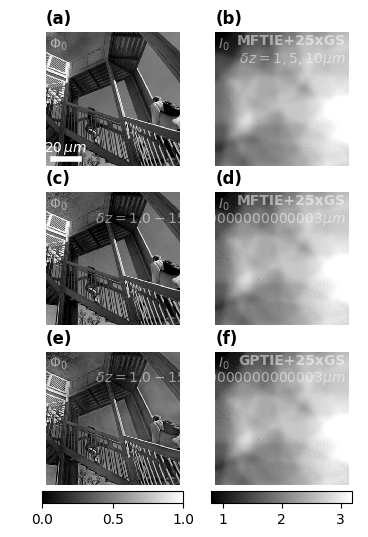

In [19]:
from string import ascii_lowercase as alph

h, w = plt.figaspect(3/2.)
f = plt.figure(figsize=(h,w))
#f = plt.figure()
axs = hs.plot.plot_images(psi_list, per_row=2, scalebar=[0,], colorbar=None, axes_decor='off', fig=f)

# set amplitude clim
for io, axi in enumerate(axs[::2]):
    imi = axi.images[0]
    imi.set_clim(vmin=0., vmax=1.)
    axi.set_title('('+alph[2*io]+')', loc='left', fontweight='bold')
    axi.text(0.02, 0.97, r'$\Phi_0$', transform=axi.transAxes, 
             fontweight='bold', color='white', ha='left', va='top', alpha=0.5)
    
# set phases clim
for io, axi in enumerate(axs[1::2]):
    imi = axi.images[0]
    imi.set_clim(vmin=0.8, vmax=3.2)
    axi.set_title('('+alph[2*io+1]+')', loc='left', fontweight='bold')
    axi.text(0.98, 0.97, labels[io][:5]+'+'+str(Niters)+'xGS\n'+labels[io][6:], 
             transform=axi.transAxes, 
             fontweight='bold', color='white', ha='right', va='top', alpha=0.5)
    axi.text(0.02, 0.97, r'$I_0$', transform=axi.transAxes, 
             fontweight='bold', color='white', ha='left', va='top', alpha=0.5)
    
sbar = axs[0].scalebar
sbar.line.set_lw(4.)
oldtxt = sbar.text.get_text()
sbar.text.set_text(oldtxt[:6]+'${\mu m}$')

f.show()
plt.pause(0.1) # wtf matplotlib

new_pos = (sbar.position[0]+10, sbar.position[1]-5.)
sbar.text.set_position(new_pos)

# custom scalebars, horizontal
posA = axs[-2].get_position()
caxA = f.add_axes([posA.x0, posA.y0-0.03, posA.width, 0.02])
cbarA = f.colorbar(axs[-2].images[0], orientation='horizontal', cax=caxA)
cbarA.set_ticks([0.0, 0.5, 1.0])

posB = axs[-1].get_position()
caxB = f.add_axes([posB.x0, posB.y0-0.03, posB.width, 0.02])
cbarB = f.colorbar(axs[-1].images[0], orientation='horizontal', cax=caxB)
cbarB.set_ticks([1., 2., 3.])

#f.subplots_adjust(wspace=0.1, hspace=0.15)

## FRC and rmse

### frc

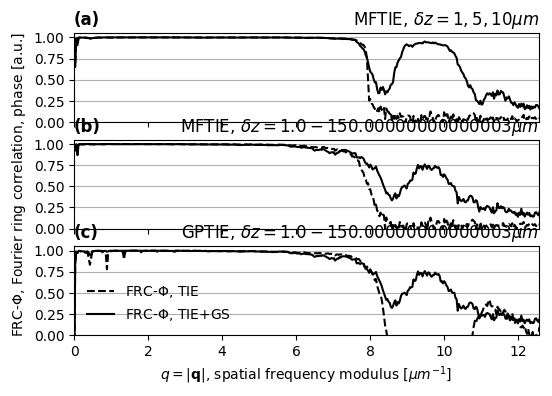

In [20]:
from string import ascii_lowercase as alph

Nplots = len(frc_list)
fig, axs = plt.subplots(Nplots, 1, sharex=True)

for io, axi in enumerate(axs):
    axi.plot(kax, frc_list[io][0], '--k')
    axi.plot(kax, frc_list[io][1], '-k')
    axi.grid(which='major',axis='y')
    axi.set_yticks([0., 0.25, 0.5, 0.75, 1.])
    axi.set_ylim(0., 1.05)
    axi.set_xlim(0., wnum)
    axi.set_title(labels[io], loc='right')
    axi.set_title('('+alph[io]+')', loc='left', fontweight='bold')

axi.legend(['FRC-$\Phi$, TIE', 'FRC-$\Phi$, TIE+GS'], loc='lower left', frameon=False)
axs[-1].set_xlabel(r'$q=|\mathbf{q}|$, spatial frequency modulus $[{\mu m}^{-1}]$')
md=Nplots // 2
axs[md].set_ylabel(r'FRC-$\Phi$, Fourier ring correlation, phase [a.u.]') 

### rmse

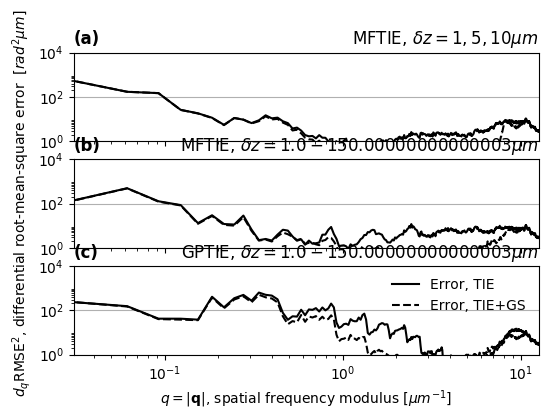

In [21]:
from string import ascii_lowercase as alph

Nplots = len(rms_list)
fig, axs = plt.subplots(Nplots,1, sharex=True)

for io, axi in enumerate(axs):
    axi.plot(kax, rms_list[io][0], '-k')
    axi.plot(kax, rms_list[io][1], '--k')
    axi.grid(which='major',axis='y')
    
    axi.set_yscale('log')
    axi.set_xscale('log')
    axi.set_ylim(1e0, 1e4)
    axi.set_xlim(0., wnum)
    
    axi.set_title(labels[io], loc='right')
    axi.set_title('('+alph[io]+')', loc='left', fontweight='bold')
    
    
axi.legend(['Error, TIE', 'Error, TIE+GS'], loc='upper right', frameon=False)

axs[-1].set_xlabel(r'$q=|\mathbf{q}|$, spatial frequency modulus $[{\mu m}^{-1}]$')
md=Nplots // 2
axs[md].set_ylabel(r'$d_q$RMSE$^2$, differential root-mean-square error  $[rad^2 {\mu m}]$')    

## Some comparisons

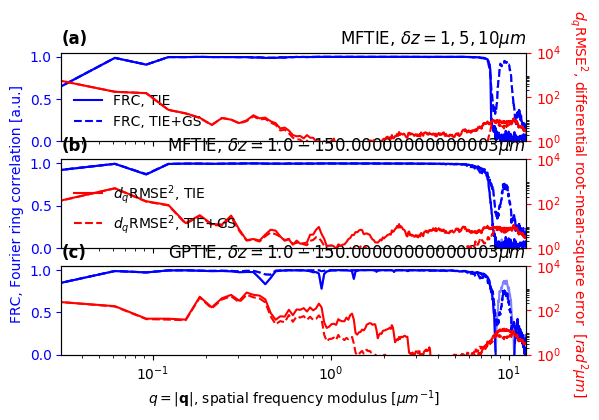

In [22]:
from string import ascii_lowercase as alph

c1 = 'b'
c2 = 'r'

Nplots = len(frc_list)
f, ax = plt.subplots(Nplots,1,sharex=True)
for io, axi in enumerate(ax):
    
    axi.plot(kax, frc_list[io][0], '-'+c1, label='FRC, TIE')
    axi.plot(kax, np.abs(frc_list[io][0]), '-'+c1, alpha=0.5)
    
    axi.plot(kax, frc_list[io][1], '--'+c1, label='FRC, TIE+GS')
    axi.plot(kax, np.abs(frc_list[io][1]), '--'+c1, alpha=0.5)
    
    axi.set_title(labels[io], loc='right')
    axi.set_title('('+alph[io]+')', loc='left', fontweight='bold')
    
    axi.set_ylim(0., 1.05)
    axi.tick_params('y', colors=c1)
    
    # twin axis
    axt = axi.twinx()
    axt.plot(kax, rms_list[io][0], '-'+c2, label=r'$d_q$RMSE$^2$, TIE' )
    axt.plot(kax, rms_list[io][1], '--'+c2, label=r'$d_q$RMSE$^2$, TIE+GS')
    
    axt.set_yscale('log')
    axt.set_xscale('log')
    axt.set_ylim(1e0, 1e4)
    axt.set_xlim(0., wnum)
    axt.tick_params('y', colors=c2)
        
f.axes[0].legend(loc='lower left', frameon=False)
f.axes[4].legend(loc='lower left', frameon=False)

ax[-1].set_xlabel(r'$q=|\mathbf{q}|$, spatial frequency modulus $[{\mu m}^{-1}]$')
md=Nplots // 2
ax[md].set_ylabel(r'FRC, Fourier ring correlation [a.u.]', color=c1)
f.axes[md+Nplots].set_ylabel(r'$d_q$RMSE$^2$, differential root-mean-square error  $[rad^2 {\mu m}]$', 
                             color=c2, va='bottom', rotation=270)    

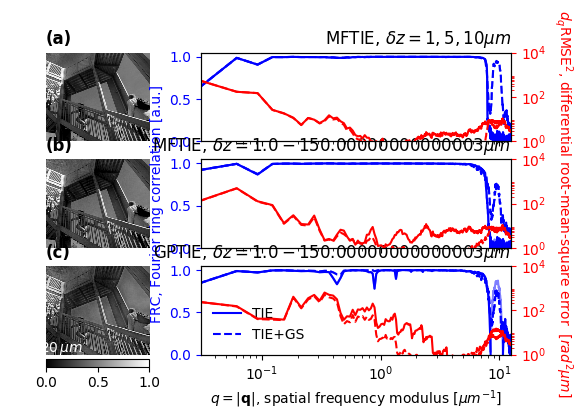

In [23]:
from string import ascii_lowercase as alph

c1 = 'b'
c2 = 'r'

Nplots = len(frc_list)
gs_kw = {'width_ratios':[1, 3], 'wspace':0.25}
f, ax = plt.subplots(Nplots,2, sharex='col', gridspec_kw=gs_kw)

#kax = sim_chi_3p[0]['frc'].axes_manager[0].axis

# images
axs = ax[:,0]
phases = [sim_gsivx['Phi'].unset_padding() + 0.3,   
          sim_mf_gs['Phi'].unset_padding() + 0.3,    
          sim_gp_gs['Phi'].unset_padding() + 0.3]

for io, axi in enumerate(axs):
    imi = axi.imshow(phases[io].data)
    imi.set_clim(vmin=0., vmax=1.)
    axi.set_axis_off()
    #axi.set_title(r'$\delta z='+str(np.round(dz[io],0))+'\mu m$', loc='right')
    axi.set_title('('+alph[io]+')', loc='left', fontweight='bold')

# sbar tech
hs.hyperspy.drawing.widgets.ScaleBar(axi, '${\mu m}$', pixel_size=0.2)

# custom scalebar, horizontal
pos = axs[-1].get_position()
cax = f.add_axes([pos.x0, pos.y0-0.03, pos.width, 0.02])
cbar = f.colorbar(axs[-1].images[0], orientation='horizontal', cax=cax)
cbar.set_ticks([0.0, 0.5, 1.0])


# validations
axl = ax[:,1]
axr = []
for io, axi in enumerate(ax[:,1]):
    
    axi.plot(kax, frc_list[io][0], '-'+c1, label='TIE')
    axi.plot(kax, np.abs(frc_list[io][0]), '-'+c1, alpha=0.5)
    
    axi.plot(kax, frc_list[io][1], '--'+c1, label='TIE+GS')
    axi.plot(kax, np.abs(frc_list[io][1]), '--'+c1, alpha=0.5)
    
    axi.set_title(labels[io], loc='right')
    #axi.set_title('('+alph[io+3]+')', loc='left', fontweight='bold')
    
    axi.set_ylim(0., 1.05)
    axi.tick_params('y', colors=c1)
    
    # twin axis
    axt = axi.twinx()
    axt.plot(kax, rms_list[io][0], '-'+c2, label=r'TIE' )
    axt.plot(kax, rms_list[io][1], '--'+c2, label=r'TIE+GS')
    
    axt.set_yscale('log')
    axt.set_xscale('log')
    axt.set_ylim(1e0, 1e4)
    axt.set_xlim(0., wnum)
    axt.tick_params('y', which='both', colors=c2)
    axr.append(axt)
    
axl[-1].legend(loc='lower left', frameon=False)

ax[-1,1].set_xlabel(r'$q=|\mathbf{q}|$, spatial frequency modulus $[{\mu m}^{-1}]$')
md=Nplots // 2
ax[md,1].set_ylabel(r'FRC, Fourier ring correlation [a.u.]', color=c1)
f.axes[md+2*Nplots+1].set_ylabel(r'$d_q$RMSE$^2$, differential root-mean-square error  $[rad^2 {\mu m}]$', 
                               color=c2, va='bottom', rotation=270)  

## Inverse Laplacian
**WARNING! This will only work properly if alpha=0**

In [53]:
nm2 = sim_mftie['Nm2'].deepcopy()
nm2.data = np.fft.fftshift(nm2.data, axes = (-2, -1))

In [54]:
k2 = fsn.get_fourier_space()
kscale = np.sqrt(k2[1,0])
k2 = np.fft.fftshift(k2, (-2,-1))

# collect inverse Laplacian
iLap = np.concatenate( [nm2.data, 
                        np.sqrt((nm2.data**2.).sum(0))[None,...],
                        (1./k2)[None,...]] )

iLap = ModI(iLap)

# compute integral
Ndec = 0
S_iLap_dr = iLap.integrate_radial(True, round_decimals=Ndec)
# Do not plot this signal directly: 
# the scale is no longer linear for Ndec > 1!!!

c:\users\johannes\anaconda3\lib\site-packages\ipykernel\__main__.py:8: RuntimeWarning: divide by zero encountered in true_divide


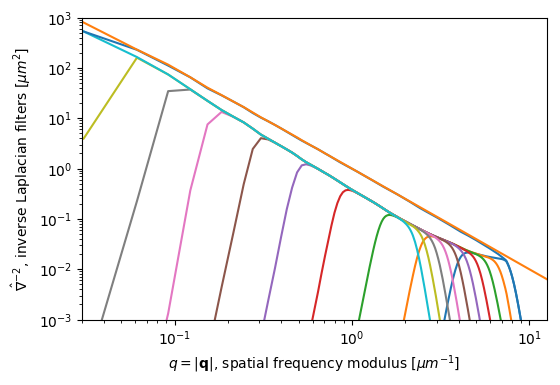

In [55]:
f = plt.figure()
ax = f.add_subplot(111)

qrnd = S_iLap_dr.axes_manager[-1].axis * kscale
for si in S_iLap_dr:
    ax.plot(qrnd, si.data, mew=0.5)

ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylim(1e-3, 1e3)
ax.set_xlim(0.03, wnum)
ax.set_xlabel(r'$q=|\mathbf{q}|$, spatial frequency modulus $[{\mu m}^{-1}]$')
ax.set_ylabel(r'$\hat\nabla^{-2}$, inverse Laplacian filters $[{\mu m}^2]$')    

# Bonus points: GFTIE example
We remove the boundary conditions from the dataset and build them again using the gradient-flipping algorithm. Also works better with alpha = 0.

In [56]:
from GFTIE import GFTIE

In [57]:
Npad = 100

fs_gftie = fsn.unset_padding()
fs_gftie = fs_gftie.set_padding(((Npad, Npad), (Npad, Npad)), 'constant', constant_values=fs_gftie.data.mean())

# Better to generate phase result anew
sim_gftie = do_mftie(fs_gftie, SNR, lothres, hithres, Nbutter=10)
ph_gftie = sim_gftie['Phi']

# Do GFTIE
D = GFTIE(fs_gftie, ph_gftie, 20, 10)
mftie = MFTIE(fs_gftie, True, 1e5, 0.25, alpha, SNR, True)
mftie.set_dzI(D)
ph_flip = mftie(False)

E:\Documents\inline_holo\MFTIE.py:288: RuntimeWarning: divide by zero encountered in true_divide
  nabla_minus_2 = (1. / k2) * (1./(1.+(k2/k2Hi[:,None,None])**Nbutter)) * \
E:\Documents\inline_holo\MFTIE.py:289: RuntimeWarning: invalid value encountered in multiply
  (1.-1./(1.+(k2/k2Lo[:,None,None])**Nbutter))
E:\Documents\inline_holo\GFTIE.py:86: RuntimeWarning: divide by zero encountered in true_divide
  nabla_minus_2 = (1. / np.repeat(k2[None,...], len(adef), 0) )


Starting GF; Rlp = 10 um


Chi2 = 0.00027181333227436675; dChi2 = 0.99997281866677260:01<00:37,  1.97s/it]
Chi2 = 0.00017793665947237193; dChi2 = 0.34537184771803714
Chi2 = 0.00016968999950742913; dChi2 = 0.04634604240293303
Chi2 = 0.00016944861889407764; dChi2 = 0.001422479898946099
Chi2 = 0.00016985846960208004; dChi2 = 0.002418731475519439
Chi2 = 0.00016979965389891106; dChi2 = 0.0003462629994651907
Chi2 = 0.00017021198277310172; dChi2 = 0.002428325763467945
Chi2 = 0.00017010382775158096; dChi2 = 0.0006354136751049649
Chi2 = 0.00017024379766524054; dChi2 = 0.0008228498765118434
Chi2 = 0.0001702014673920425; dChi2 = 0.0002486450242450474
Chi2 = 0.00017033776469826901; dChi2 = 0.0008007998304301641
Chi2 = 0.00017036976754306577; dChi2 = 0.00018787874112032626
Chi2 = 0.00017044293406194677; dChi2 = 0.0004294571738645043
Chi2 = 0.00017049430296976623; dChi2 = 0.00030138478959055676
Chi2 = 0.00017055932862026943; dChi2 = 0.00038139485818907564
Chi2 = 0.00017069515844249833; dChi2 = 0.0007963787341782417
Chi2 = 0.0

In [58]:
# Get in-focus Amplitude
Nm  = get_middle(fs_gftie)
amp = fs_gftie.inav[Nm]

# Get init-waves
wave_gf = sim_gftie['Phi'].deepcopy()
wave_gf.data = np.sqrt(amp.data) * np.exp(1j*sim_gftie['Phi'].data)

# Get CTF
ctf = amp.get_contrast_transfer(zdef)

# Do GSref !!
sim_gf_gs = do_gsref(fs_gftie, wave_gf, ctf, Niters)

E:\Documents\inline_holo\inline_holo.py:502: RuntimeWarning: invalid value encountered in sqrt
  Chi = np.sqrt(wnum**2-k2) - wnum

  0%|                                                   | 0/25 [00:00<?, ?it/s]
Exception in thread Thread-72:
Traceback (most recent call last):
  File "c:\users\johannes\anaconda3\lib\threading.py", line 914, in _bootstrap_inner
    self.run()
  File "c:\users\johannes\anaconda3\lib\site-packages\tqdm\_tqdm.py", line 103, in run
    for instance in self.tqdm_cls._instances:
  File "c:\users\johannes\anaconda3\lib\_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration

100%|██████████████████████████████████████████| 25/25 [00:03<00:00,  6.58it/s]


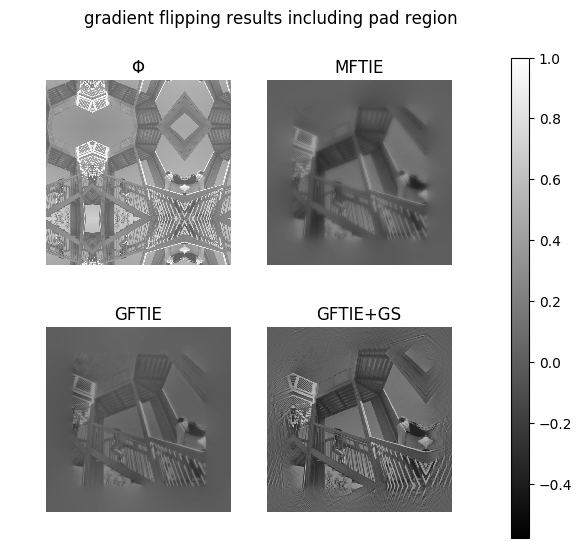

In [59]:
hs.plot.plot_images([phase_org, ph_gftie, 
                     ph_flip, sim_gf_gs['Phi']], 
                    label=[r'$\Phi$', 'MFTIE', 'GFTIE', 'GFTIE+GS'],
                    per_row=2, axes_decor='off', colorbar='single')
plt.suptitle('gradient flipping results including pad region')

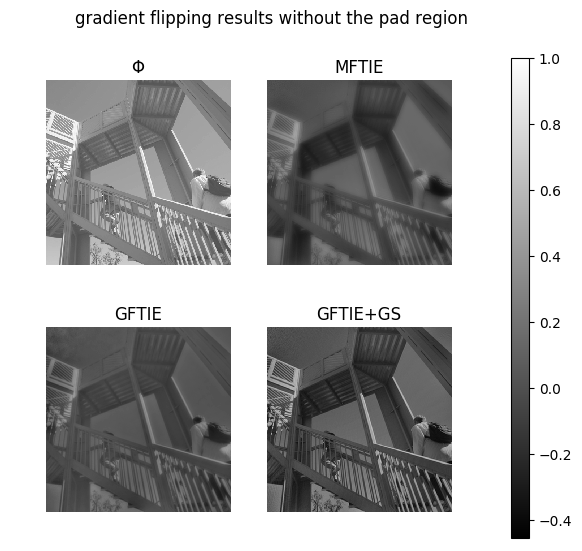

In [60]:
hs.plot.plot_images([phase_org.unset_padding(), ph_gftie.unset_padding(), 
                     ph_flip.unset_padding(), sim_gf_gs['Phi'].unset_padding()], 
                    label=[r'$\Phi$', 'MFTIE', 'GFTIE', 'GFTIE+GS'],
                    per_row=2, axes_decor='off', colorbar='single')
plt.suptitle('gradient flipping results without the pad region')

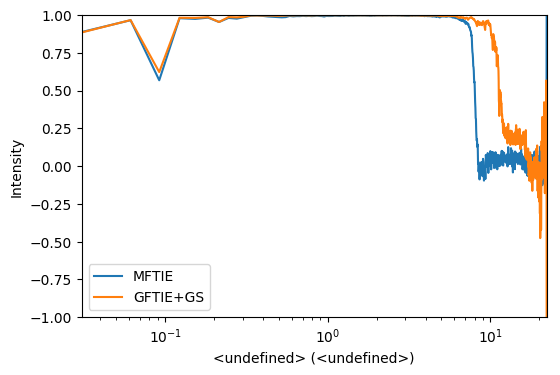

In [61]:
f, ax = plt.subplots(1,1)
hs.plot.plot_spectra([sim_gftie['frc'], sim_gf_gs['frc_phi']], 
                     legend=['MFTIE', 'GFTIE+GS'], legend_loc='best', 
                     fig=f, ax=ax)
ax.set_xscale('log')